# data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
# create a plot of generated images (reversed grayscale)
def show_plot(examples, n, with_channel=True):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        if with_channel:
            # shape = (n_sample, x_axis, y_axis, channel)
            plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        else:
            # shape = (n_sample, x_axis, y_axis)
            plt.imshow(examples[i], cmap='gray_r')
            
    plt.show()
    
def t_sne_visualize(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj = tsne.fit_transform(x)

    tsne_df = pd.DataFrame({'X': tsne_obj[:, 0],
                            'Y': tsne_obj[:, 1],
                            'classes': y})
    sns.scatterplot(x="X", y="Y",
                    hue="classes",
                    legend='full',
                    size=0.5,
                    alpha=0.2,
                    data=tsne_df)
    plt.show()

In [3]:
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data pre-processing
# flat the input data
x_train = x_train.reshape(*x_train.shape, 1) / 255.    # normalize
x_test = x_test.reshape(*x_test.shape, 1) / 255.      # normalize

# one-hot output data
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Using TensorFlow backend.


# trival autoencoder

In [4]:
from keras.layers import Input, Dense
from keras.models import Model

In [11]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [14]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2779 - val_loss: 0.1934
Epoch 2/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1728 - val_loss: 0.1548
Epoch 3/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1449 - val_loss: 0.1341
Epoch 4/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1289 - val_loss: 0.1214
Epoch 5/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1185 - val_loss: 0.1130
Epoch 6/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1113 - val_loss: 0.1070
Epoch 7/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1061 - val_loss: 0.1027
Epoch 8/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1023 - val_loss: 0.0994
Epoch 9/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0994 - val_loss: 0.0970
Epoch 10/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0975 - val_loss: 0.0954

In [15]:
# encode and decode some digits
# note that we take them from the *test* set

# encoded_imgs = encoder.predict(x_test)
# decoded_imgs = decoder.predict(encoded_imgs)

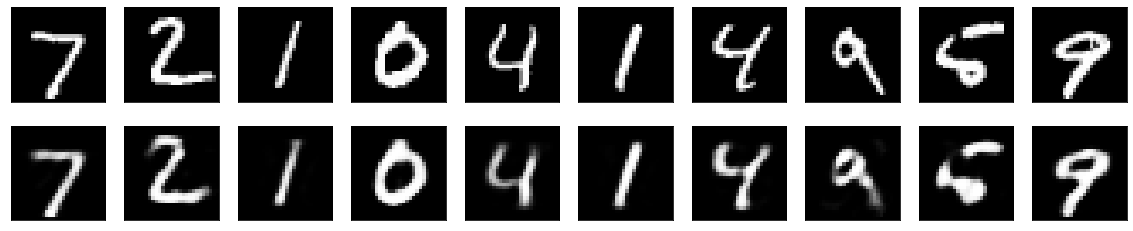

In [17]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# convolutional autoencoder

In [18]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [22]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [23]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [24]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2072 - val_loss: 0.1426
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1330 - val_loss: 0.1246
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1218 - val_loss: 0.1177
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1155 - val_loss: 0.1119
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1115 - val_loss: 0.1095
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1088 - val_loss: 0.1062
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1067 - val_loss: 0.1043
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1049 - val_loss: 0.1028
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1035 - val_loss: 0.1014
Epoch 10/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1021 - val_loss: 0.1004

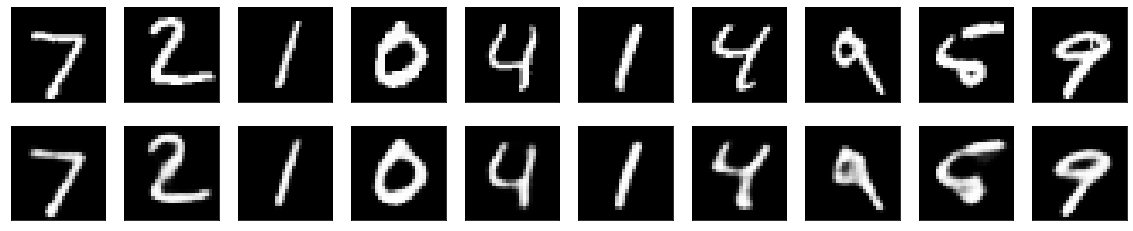

In [26]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# variational autoencoder

In [29]:
from keras.layers import Lambda
from keras.losses import mse, binary_crossentropy

In [42]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

def vae_loss2(inputs, outputs):
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

# network parameters
original_dim = np.prod(x_train.shape[1:])
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
# decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
                       
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# variational autoencoder

In [59]:
import tensorflow as tf
import keras
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        return self.decoder(self.encoder(x)[-1])
    
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 14, 14, 32)   320         input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_28[0][0]                  
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 3136)         0           conv2d_29[0][0]                  
____________________________________________________________________________________________

In [60]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 4s 8ms/step - loss: 215.1175 - reconstruction_loss: 212.8813 - kl_loss: 2.2361 - val_loss: 0.0000e+00
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 188.1189 - reconstruction_loss: 185.8017 - kl_loss: 2.3172 - val_loss: 0.0000e+00
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 171.8159 - reconstruction_loss: 168.4663 - kl_loss: 3.3496 - val_loss: 0.0000e+00
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 162.2231 - reconstruction_loss: 158.4415 - kl_loss: 3.7816 - val_loss: 0.0000e+00
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 158.6389 - reconstruction_loss: 154.8078 - kl_loss: 3.8311 - val_loss: 0.0000e+00
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 156.3907 - reconstruction_loss: 152.5543 - kl_loss: 3.8364 - val_loss: 0.0000e+00
Epoch 7/50
469/469 [==============================] - 4s 8ms/ste

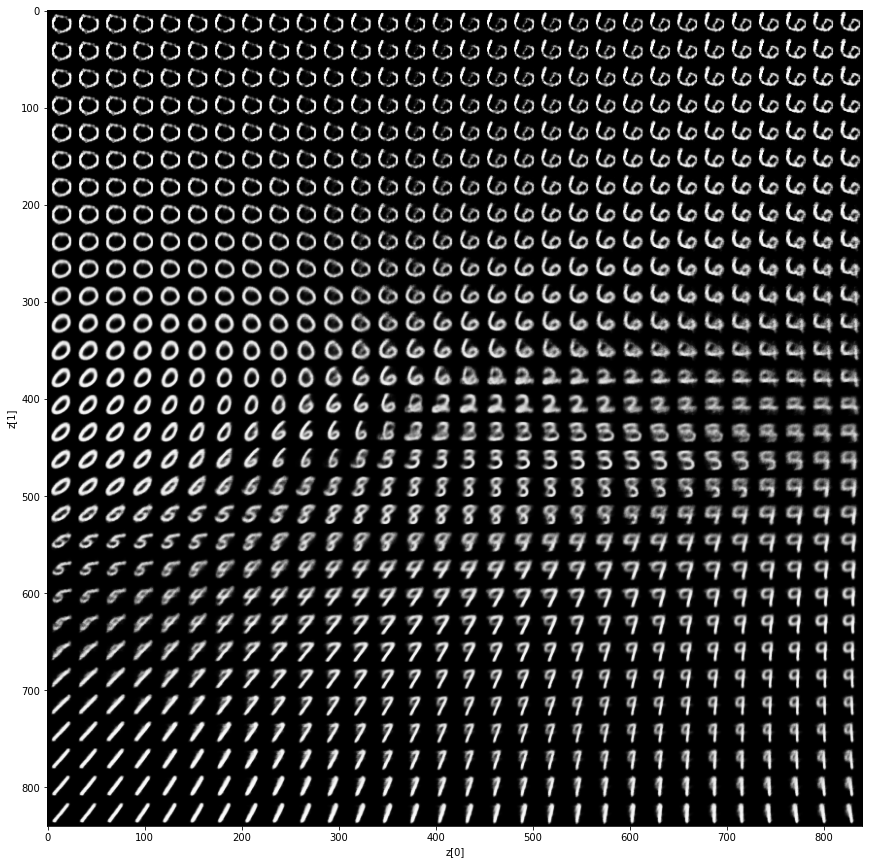

In [62]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # start_range = digit_size // 2
    # end_range = n * digit_size + start_range + 1
    # pixel_range = np.arange(start_range, end_range, digit_size)
    # sample_range_x = np.round(grid_x, 1)
    # sample_range_y = np.round(grid_y, 1)
    # plt.xticks(pixel_range, sample_range_x)
    # plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)